In [0]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 1.4MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4535934 sha256=1cbaf0494b1869bfd506b7156c125a089bb7641b30cda01208d46112fad54e66
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2020.1-py2.py3-none-any.whl size=59602 sha256=ac85736d04afa6b647094ae9e2ac3153704b788eccf4826da2a730fb619b63dd
  Stored in directory: /root/.cache/pip/wheels/6f/da/1b/946775a88291378182ed92c9800d6d0ebc2a554cb89829cc24
Successfully built pycuda pytools


Import standard.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

PyCUDA imports

In [0]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

```iDivUp``` function: if ```b``` divides ```a```, then ```a/b``` is returned, otherwise the function returns the integer division between ```a``` and ```b``` summed to ```1```.

In [0]:
###################
# iDivUp FUNCTION #
###################
def iDivUp(a, b):
    # Round a / b to nearest higher integer value
    a = np.int32(a)
    b = np.int32(b)
    return (a / b + 1) if (a % b != 0) else (a / b)

Kernel functions.

In [0]:
BLOCKSIZEX = 16
BLOCKSIZEY = 16

kernelFunctions = """

#include <stdio.h>

#define BLOCKSIZEX		%(BBLOCKSIZEX)s
#define BLOCKSIZEY		%(BBLOCKSIZEY)s

extern "C" {

/********************************************************/
/* DEVICE-SIZE FIELD UPDATE FUNCTION - NO SHARED MEMORY */
/********************************************************/
__global__ void updateDevice_v0(const double * __restrict__ d_uold, const double * __restrict__ d_u, double * __restrict__ d_unew, const double c, const double q, const double r, const int Nx, const int Ny) {
	
	const int tidx = threadIdx.x + blockIdx.x * blockDim.x;
	const int tidy = threadIdx.y + blockIdx.y * blockDim.y;

	if ((tidx >= Nx - 1) || (tidx == 0) || (tidy >= Ny - 1) || (tidy == 0)) return;
		
	d_unew[tidy * Nx + tidx] = q * d_u[tidy * Nx + tidx] + r * d_uold[tidy * Nx + tidx] + c * (d_u[tidy * Nx + tidx - 1] + d_u[tidy * Nx + tidx + 1] + d_u[(tidy + 1) * Nx + tidx] + d_u[(tidy - 1) * Nx + tidx] - 4. * d_u[tidy * Nx + tidx]);
}

/********************************************************/
/* DEVICE-SIZE FIELD UPDATE FUNCTION - SHARED MEMORY v1 */
/********************************************************/
__global__ void updateDevice_v1(const double * __restrict__ d_uold, const double * __restrict__ d_u, double * __restrict__ d_unew, const double c, const double q, const double r, const int Nx, const int Ny) {

	const int tidx = threadIdx.x + blockIdx.x * blockDim.x;
	const int tidy = threadIdx.y + blockIdx.y * blockDim.y;

	if ((tidx >= Nx) || (tidy >= Ny)) return;

	__shared__ double d_u_sh[BLOCKSIZEX][BLOCKSIZEY];

	/* --- Load data to shared memory. Halo regions are NOT loaded. */
	d_u_sh[threadIdx.x][threadIdx.y] = d_u[tidy * Nx + tidx];
	__syncthreads();

	if ((threadIdx.x > 0) && (threadIdx.x < (BLOCKSIZEX - 1)) && (threadIdx.y > 0) && (threadIdx.y < (BLOCKSIZEY - 1)) && (tidx < (Nx - 1)) && (tidy < (Ny - 1))) 

		/* --- If we do not need halo region elements, then use shared memory. */
		d_unew[tidy * Nx + tidx] = q * d_u_sh[threadIdx.x][threadIdx.y] + r * d_uold[tidy * Nx + tidx] + c * (d_u_sh[threadIdx.x - 1][threadIdx.y] + d_u_sh[threadIdx.x + 1][threadIdx.y] + d_u_sh[threadIdx.x][threadIdx.y - 1] +
		                           d_u_sh[threadIdx.x][threadIdx.y + 1] - 4. * d_u_sh[threadIdx.x][threadIdx.y]);

	else if (tidx > 0 && tidx < Nx - 1 && tidy > 0 && tidy < Ny - 1)  
		
		/* --- If we need halo region elements, then use global memory. */
		d_unew[tidy * Nx + tidx] = q * d_u[tidy * Nx + tidx] + r * d_uold[tidy * Nx + tidx] + c * (d_u[tidy * Nx + tidx - 1] + d_u[tidy * Nx + tidx + 1] + d_u[(tidy + 1) * Nx + tidx] + d_u[(tidy - 1) * Nx + tidx] - 4. * d_u[tidy * Nx + tidx]);

}

/********************************************************/
/* DEVICE-SIZE FIELD UPDATE FUNCTION - SHARED MEMORY v3 */
/********************************************************/
__global__ void updateDevice_v2(const double * __restrict__ d_uold, const double * __restrict__ d_u, double * __restrict__ d_unew, const double c, const double q, const double r, const int Nx, const int Ny) {

	const int tidx = blockIdx.x * blockDim.x + threadIdx.x;
	const int tidy = blockIdx.y * blockDim.y + threadIdx.y;

	if ((tidx >= Nx) || (tidy >= Ny)) return;

	const int tid_block = threadIdx.y * BLOCKSIZEX + threadIdx.x;		/* --- Flattened thread index within a block */

	const int tidx1 = tid_block %% (BLOCKSIZEX + 2);
	const int tidy1 = tid_block / (BLOCKSIZEY + 2);

	const int tidx2 = (BLOCKSIZEX * BLOCKSIZEY + tid_block) %% (BLOCKSIZEX + 2);
	const int tidy2 = (BLOCKSIZEX * BLOCKSIZEY + tid_block) / (BLOCKSIZEY + 2);

	__shared__ double d_u_sh[BLOCKSIZEX + 2][BLOCKSIZEY + 2];

	/* bool test1 = ((blockIdx.x * BLOCKSIZEX - 1 + tidx1) < Nx);
	bool test2 = ((blockIdx.x * BLOCKSIZEX - 1 + tidx1) >= 0); */
	
	if (((blockIdx.x * BLOCKSIZEX - 1 + tidx1) < Nx) && ((blockIdx.x * BLOCKSIZEX - 1 + tidx1) >= 0) && ((blockIdx.y * BLOCKSIZEY - 1 + tidy1) < Ny) && ((blockIdx.y * BLOCKSIZEY - 1 + tidy1) >= 0)) 
		d_u_sh[tidx1][tidy1] = d_u[(blockIdx.x * BLOCKSIZEX - 1 + tidx1) + (blockIdx.y * BLOCKSIZEY - 1 + tidy1) * Nx];
	
	if (((tidx2 < (BLOCKSIZEX + 2)) && (tidy2 < (BLOCKSIZEY + 2))) && ((blockIdx.x * BLOCKSIZEX - 1 + tidx2) < Nx) && ((blockIdx.x * BLOCKSIZEX - 1 + tidx2) >= 0) && ((blockIdx.y * BLOCKSIZEY - 1 + tidy2) < Ny) && ((blockIdx.y * BLOCKSIZEY - 1 + tidy2) >= 0))
		d_u_sh[tidx2][tidy2] = d_u[(blockIdx.x * BLOCKSIZEX - 1 + tidx2) + (blockIdx.y * BLOCKSIZEY - 1 + tidy2) * Nx];

	__syncthreads();
	
	if ((tidx > 0 && tidx < Nx - 1 && tidy > 0 && tidy < Ny - 1))

	d_unew[tidy * Nx + tidx] = q * d_u_sh[threadIdx.x + 1][threadIdx.y + 1] + r * d_uold[tidy * Nx + tidx] + c * (d_u_sh[threadIdx.x][threadIdx.y + 1] + d_u_sh[threadIdx.x + 2][threadIdx.y + 1] + d_u_sh[threadIdx.x + 1][threadIdx.y] +
										 				d_u_sh[threadIdx.x + 1][threadIdx.y + 2] - 4. * d_u_sh[threadIdx.x + 1][threadIdx.y + 1]);
}
}

"""

kernelFunctions = kernelFunctions % { "BBLOCKSIZEX" : BLOCKSIZEX , "BBLOCKSIZEY" : BLOCKSIZEY}

mod = SourceModule(kernelFunctions, no_extern_c = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(75): warning: pointless comparison of unsigned integer with zero

kernel.cu(75): warning: pointless comparison of unsigned integer with zero

kernel.cu(78): warning: pointless comparison of unsigned integer with zero

kernel.cu(78): warning: pointless comparison of unsigned integer with zero




Set references to the ```__global__``` functions.

In [0]:
updateDevice_v0    = mod.get_function("updateDevice_v0")
updateDevice_v1    = mod.get_function("updateDevice_v1")
updateDevice_v2    = mod.get_function("updateDevice_v2")

Parameters.

In [0]:
Nx                  = 512                  # --- Number of discretization points along x
Ny                  = 512                  # --- Number of discretization points along y
Lx                  = 200                  # --- Dimension of the computational domain along x
Ly                  = 200                  # --- Dimension of the computational domain along y
v                   = 5                    # --- Propagation speed
p                   = 0.02								 # --- Wave decay factor	

Space-time discretization.

In [0]:
x, dx = np.linspace(0, Lx, Nx, retstep = True)                                    # --- Discretization points along x
y, dy = np.linspace(0, Ly, Ny, retstep = True)                                    # --- Discretization points along y
X, Y  = np.meshgrid(x, y)  

dt    = 0.25 / (v * np.sqrt((1 / dx) * (1 / dx) + (1 / dy) * (1 / dy)));          # --- Time-step according to the Courant-Friedrichs-Lewy condition
T     = np.floor((2 * np.sqrt(Lx * Lx + Ly * Ly) / v) / dt);                      # --- Total number of time steps
t     = range(0, np.int32(T)) * dt                                                # --- Temporal discretization

c     = dt * dt * v * v / (dx * dx) 									                            # --- CFL number
q     = 2 - p * dt
r     = -1 + p * dt

Source size and position.

In [0]:
indxc               = np.floor(Nx / 3) - 1                                        # --- Source index along x
indyc               = np.floor(Ny / 2) - 1                                        # --- Source index along y
xc                  = x[np.int32(indxc)]                                          # --- x-coordinate of the source
yc                  = y[np.int32(indyc)]                                          # --- y-coordinate of the source
indRc               = 50                                                          # --- Total number of source pixels
Rc                  = Lx / indRc                                                  # --- Source radius

Initial step.

In [0]:
alphaSquared        = np.power(dt * v / dx, 2)   # --- CFL number

ind                 = np.where(np.sqrt((X - xc) * (X - xc) + (Y - yc) * (Y - yc)) <= Rc) 

indy                = slice(1, Ny - 1, 1)
indx                = slice(1, Nx - 1, 1)
indxp               = slice(2, Nx,     1)
indxm               = slice(0, Nx - 2, 1)
indyp               = slice(2, Ny,     1)
indym               = slice(0, Ny - 2, 1)

u                   = np.zeros((Ny, Nx))                                          # --- Current source u(x, y, t) - host
u_old               = np.zeros((Ny, Nx))                                          # --- Source at the previous step u_old(x, y, t) - host
u_new               = np.zeros((Ny, Nx))                                          # --- New solution u_new(x, y, t) - host

# --- Initial conditions
maskInit            = np.zeros(X.shape)
indMask             = np.where(np.sqrt((X - xc) * (X - xc) + (Y - yc) * (Y - yc)) <= Rc)
maskInit[indMask]   = 1.
u                   = np.exp(-indRc * ((X - xc) * (X - xc) + (Y - yc) * (Y - yc)) / Lx)
u                   = u * maskInit
u_old               = u

Showing the initial condition.

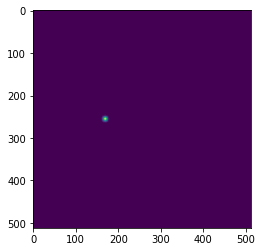

In [0]:
fig = plt.figure()
im = plt.imshow(u, interpolation = 'none')

Recording host updates (skip if GPU).

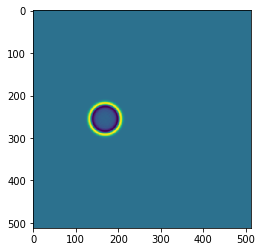

In [0]:
fig = plt.figure()

imSequence = []
for tt in range(0, 200):

    global u_new, u, u_old, Nx, Ny, q, r, c 
    
    # --- Computing the new solution
    u_new[1 : Ny - 1, 1 : Nx - 1] = q * u[1 : Ny - 1, 1 : Nx - 1] + r * u_old[1 : Ny - 1, 1 : Nx - 1] + c * (u[1 : Ny - 1, 0 : Nx - 2] + u[1 : Ny - 1, 2 : Nx] + u[2 : Ny, 1 : Nx - 1] + u[0 : Ny - 2, 1 : Nx - 1] - 4 * u[1 : Ny - 1, 1 : Nx - 1])

	  # --- Curent solution becomes old
    u_old = u
    # --- New solution becomes current																  
    u     = u_new																
    u_new = u_old

    im = plt.imshow(u, interpolation = 'none')
    imSequence.append([im])

Animation (skip if GPU).

In [0]:
anim = animation.ArtistAnimation(fig, imSequence, interval = 50, blit = True)
# anim.save('waveEquation2D.mp4')

rc('animation', html = 'jshtml')
anim

Allocate solution on device.

In [0]:
# --- Allocate device memory space for solution
d_u     = cuda.mem_alloc(Nx * Ny * 8)
d_uold  = cuda.mem_alloc(Nx * Ny * 8)
d_unew  = cuda.mem_alloc(Nx * Ny * 8)
# --- Set memory to zero
cuda.memset_d32(d_u,    0x00, Nx * Ny)
cuda.memset_d32(d_uold, 0x00, Nx * Ny)
cuda.memset_d32(d_unew, 0x00, Nx * Ny)

Transfering the initial condition from host to device.

In [0]:
cuda.memcpy_htod(d_uold, u_old)
cuda.memcpy_htod(d_u,    u)

Solution at the subsequent steps.

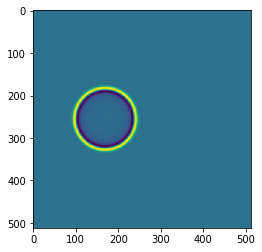

In [0]:
fig = plt.figure()

blockDim  = (BLOCKSIZEX, BLOCKSIZEY, 1)
gridDim   = (int(iDivUp(Nx, BLOCKSIZEX)), int(iDivUp(Ny, BLOCKSIZEY)), 1)

imSequence = []
for tt in range(0, 400):

    global d_unew, d_u, d_uold, Nx, Ny, q, r, c 
    
	  # --- Computing the new solution
    # updateDevice_v0(d_uold, d_u, d_unew, np.float64(c), np.float64(q), np.float64(r), np.int32(Nx), np.int32(Ny), block = blockDim, grid = gridDim)
    updateDevice_v1(d_uold, d_u, d_unew, np.float64(c), np.float64(q), np.float64(r), np.int32(Nx), np.int32(Ny), block = blockDim, grid = gridDim)
    # updateDevice_v2(d_uold, d_u, d_unew, np.float64(c), np.float64(q), np.float64(r), np.int32(Nx), np.int32(Ny), block = blockDim, grid = gridDim)
 
    u_graph             = np.zeros((Ny, Nx))                                          # --- Current source u(x, y, t) - host
    
    cuda.memcpy_dtoh(u_graph, d_unew)
		
	  # --- Curent solution becomes old
    #d_uold = d_u
    cuda.memcpy_dtod(d_uold, d_u, Nx * Ny * 8)
    # --- New solution becomes current																  
    #d_u    = d_unew				
    cuda.memcpy_dtod(d_u, d_unew, Nx * Ny * 8)												
    #d_unew = d_uold
    cuda.memcpy_dtod(d_unew, d_uold, Nx * Ny * 8)												

    im = plt.imshow(u_graph, interpolation = 'none')
    imSequence.append([im])

Animation.

In [0]:
anim = animation.ArtistAnimation(fig, imSequence, interval = 50, blit = True)
anim.save('waveEquation2D.mp4')

rc('animation', html = 'jshtml')
anim